In [13]:
!pip install faiss-cpu


In [14]:
!pip install sentence-transformers networkx numpy


In [15]:
!pip install matplotlib


In [16]:
documents = [
    {
        "id": "doc1",
        "title": "Machine Learning",
        "text": "Machine learning allows systems to learn from data. Supervised and unsupervised learning are common types."
    },
    {
        "id": "doc2",
        "title": "Deep Learning",
        "text": "Deep learning is a subset of machine learning. It uses neural networks with many layers."
    },
    {
        "id": "doc3",
        "title": "RAG",
        "text": "Retrieval Augmented Generation combines retrieval systems with large language models."
    },
    {
        "id": "doc4",
        "title": "Graph Neural Networks",
        "text": "Graph neural networks work on graph structured data like nodes and edges."
    }
]


In [17]:
def chunk_text(text, chunk_size=20):
    words = text.split()
    chunks = []
    for i in range(0, len(words), chunk_size):
        chunk = " ".join(words[i:i+chunk_size])
        chunks.append(chunk)
    return chunks


chunks = []
metadata = []

for doc in documents:
    doc_chunks = chunk_text(doc["text"])
    for chunk in doc_chunks:
        chunks.append(chunk)
        metadata.append({
            "doc_id": doc["id"],
            "title": doc["title"]
        })


In [18]:
from sentence_transformers import SentenceTransformer
import faiss
import numpy as np

# Load embedding model
model = SentenceTransformer("all-MiniLM-L6-v2")

# Create embeddings
embeddings = model.encode(chunks)

# FAISS index
dimension = embeddings.shape[1]
index = faiss.IndexFlatL2(dimension)

index.add(np.array(embeddings))

print("Total chunks stored in FAISS:", index.ntotal)


Total chunks stored in FAISS: 4


In [19]:
import networkx as nx

graph = nx.Graph()

# Add document nodes
for doc in documents:
    graph.add_node(doc["id"], title=doc["title"])

# Manually define relationships (dummy but realistic)
graph.add_edge("doc1", "doc2", relation="subset")
graph.add_edge("doc1", "doc3", relation="used_in")
graph.add_edge("doc2", "doc4", relation="inspired")


In [20]:
def graph_rag_query(query, top_k=2):
    # Step 1: Vector search
    query_embedding = model.encode([query])
    distances, indices = index.search(np.array(query_embedding), top_k)

    retrieved_chunks = []
    related_docs = set()

    for idx in indices[0]:
        retrieved_chunks.append(chunks[idx])
        related_docs.add(metadata[idx]["doc_id"])

    # Step 2: Graph traversal
    graph_context = []
    for doc_id in related_docs:
        neighbors = graph.neighbors(doc_id)
        for n in neighbors:
            graph_context.append(f"Related Doc: {n} - {graph.nodes[n]['title']}")

    return retrieved_chunks, graph_context


In [26]:
query = "What is the relationship between machine learning and deep learning?"

retrieved_text, graph_info = graph_rag_query(query)

print("🔹 Retrieved Chunks:")
for t in retrieved_text:
    print("-", t)

print("\n🔹 Graph Context:")
for g in graph_info:
    print("-", g)


🔹 Retrieved Chunks:
- Deep learning is a subset of machine learning. It uses neural networks with many layers.
- Machine learning allows systems to learn from data. Supervised and unsupervised learning are common types.

🔹 Graph Context:
- Related Doc: doc1 - Machine Learning
- Related Doc: doc4 - Graph Neural Networks
- Related Doc: doc2 - Deep Learning
- Related Doc: doc3 - RAG


In [27]:
# Extract doc_ids from graph_info output
related_docs = set()

for info in graph_info:
    doc_id = info.split(":")[1].split("-")[0].strip()
    related_docs.add(doc_id)

related_docs


{'doc1', 'doc2', 'doc3', 'doc4'}

In [28]:
import networkx as nx
import matplotlib.pyplot as plt

def build_query_graph(full_graph, related_docs):
    query_graph = nx.Graph()

    for doc in related_docs:
        # Add main node
        query_graph.add_node(doc, title=full_graph.nodes[doc]["title"])

        # Expand neighbors
        for neighbor in full_graph.neighbors(doc):
            query_graph.add_node(
                neighbor,
                title=full_graph.nodes[neighbor]["title"]
            )
            query_graph.add_edge(
                doc,
                neighbor,
                relation=full_graph.edges[doc, neighbor]["relation"]
            )
    return query_graph


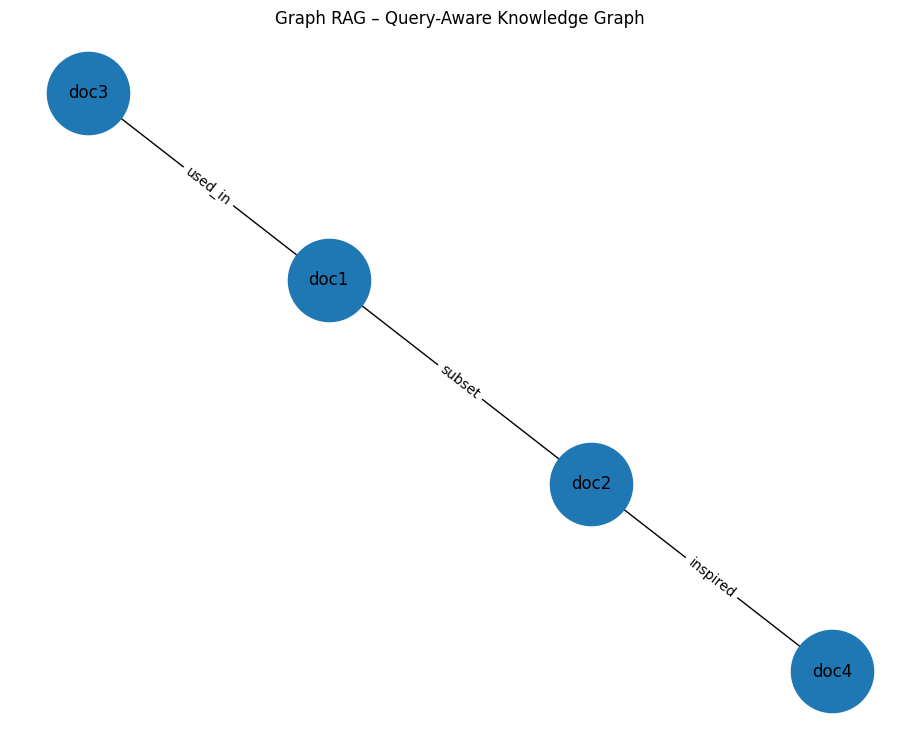

In [29]:
query_graph = build_query_graph(graph, related_docs)

plt.figure(figsize=(9,7))
pos = nx.spring_layout(query_graph, seed=42)

nx.draw(
    query_graph,
    pos,
    with_labels=True,
    node_size=3500
)

edge_labels = nx.get_edge_attributes(query_graph, "relation")
nx.draw_networkx_edge_labels(
    query_graph,
    pos,
    edge_labels=edge_labels
)

plt.title("Graph RAG – Query-Aware Knowledge Graph")
plt.show()
